## Постановка проблемы



Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Поставлена задача создать такую модель.

## Импортируем библиотеки

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# фиксируем RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Загрузка данных

In [4]:
# Подгрузим наши данные из соревнования

df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\Anna\AppData\Local\Temp\ipykernel_15612\447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


## Очистка данных

In [12]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Пропуски встречены только в столбцах координат отеля. Заполним их модой.

In [14]:
data = data.fillna({'lat':data['lat'].mode()[0], 'lng':data['lng'].mode()[0]})

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Анализ данных

### Преобразование признаков


1. Извлекаем страну отеля

In [16]:
# Посмотрим, как представлена информация в столбце
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [17]:
# Функция для извлечения названия страны
def country(feature):
    address_list = feature.split()
    if address_list[-2]=='United':
        country = address_list[-2]+' '+address_list[-1]
    else:
        country = address_list[-1]
    return country
    

In [18]:
# Создаем столбец с названием страны
data['country'] = data['hotel_address'].apply(country)

2. Преобразуем дату отзыва в соответствующий формат

In [19]:
data['review_date'] = pd.to_datetime(data['review_date'])

3. Преобразуем теги из строки в список

In [20]:
# Создаем функцию по преобразованию строки с тегами в список
def tags(feature):
    feature = feature.replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    feature = feature.split(',')
    return feature

In [21]:
# Применим функцию к столбцу
data['tags'] = data['tags'].apply(tags)

In [22]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[Leisuretrip, Couple, DoubleRoom, Stayed2nights]",13 days,45.533137,9.171102,0,0.0,Italy
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[Leisuretrip, Group, TripleRoom, Stayed1night]",234 day,52.385649,4.834443,0,0.0,Netherlands
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[Businesstrip, Solotraveler, TwinRoom, Stayed1...",616 day,41.393192,2.161520,0,0.0,Spain


4. Оставляем только числовое значение в столбце количества дней от отзыва

In [23]:
# Создаем функцию для извлечения числового значения из признака
def days(feature):
    feature_list = feature.split()
    num_days = int(feature_list[0])
    return num_days

In [24]:
# Применим функцию к столбцу
data['days_since_review'] = data['days_since_review'].apply(days)

In [25]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[Leisuretrip, Couple, DoubleRoom, Stayed2nights]",13,45.533137,9.171102,0,0.0,Italy
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[Leisuretrip, Group, TripleRoom, Stayed1night]",234,52.385649,4.834443,0,0.0,Netherlands
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[Businesstrip, Solotraveler, TwinRoom, Stayed1...",616,41.393192,2.161520,0,0.0,Spain


5. Рассмотрим столбцы негативных и позитивных отзывов

In [26]:
# Посмотрим, как представлена информация в столбце
data['positive_review'].value_counts()

No Positive                                                                                                                                                35946
 Location                                                                                                                                                   9222
 Everything                                                                                                                                                 2284
 location                                                                                                                                                   1677
 Nothing                                                                                                                                                    1243
                                                                                                                                                           ...  
 Lots places to eat near Also near

In [27]:
# Посмотрим, как представлена информация в столбце
data['negative_review'].value_counts()

No Negative                                                                                                                                                                                                             127890
 Nothing                                                                                                                                                                                                                 14295
 Nothing                                                                                                                                                                                                                  4236
 nothing                                                                                                                                                                                                                  2225
 N A                                                                                                        

Будем принимать No negative/No positive/Nothing за 0, остальные отзывы за 1

In [28]:
# Создаем функцию для присвоения признакам положительных и отрицательных отзывов бинарных значений
def pos_neg_rev(feature):
    variants = ['no positive', 'no negative', 'nothing']
    feature = feature.lower().strip()
    if feature in variants:
        return 0
    else:
        return 1

In [29]:
# Применим функцию к столбцам
data['positive_review'] = data['positive_review'].apply(pos_neg_rev)
data['negative_review'] = data['negative_review'].apply(pos_neg_rev)

In [30]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,1,52,16670,1,62,1,"[Leisuretrip, Couple, DoubleRoom, Stayed2nights]",13,45.533137,9.171102,0,0.0,Italy
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,1,10,5018,0,0,7,"[Leisuretrip, Group, TripleRoom, Stayed1night]",234,52.385649,4.834443,0,0.0,Netherlands
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,1,3,351,1,5,15,"[Businesstrip, Solotraveler, TwinRoom, Stayed1...",616,41.393192,2.161520,0,0.0,Spain


## Создание новых признаков

1. Извлечем из признака даты дни недели, а также сезон посещения отелей

In [31]:
data['week_day'] = data['review_date'].dt.dayofweek
data['month'] = data['review_date'].dt.month

# Создаем функцию, которая разделит будние дни и выходные. 
# Присвоим будням значение 0, а выходным - 1
def weekend(feature):
    if feature in [0,1,2,3,4]:
        return 0
    else:
        return 1

# Добавляем столбец
data['is_weekend'] = data['week_day'].apply(weekend)    
    
# Разделим месяцы на времена года
def season(feature):
    if feature in [12, 1, 2]:
        return 'winter'
    elif feature in [3, 4, 5]:
        return 'spring'
    elif feature in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

# Добавляем столбец с информацией о сезоне
data['season'] = data['month'].apply(season)

In [32]:
# Закодируем признак сезона посещения
# Так как уникальных значений <15, используем класс OneHotEncoder
import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['season'])
season_bin = encoder.fit_transform(data['season'])
data = pd.concat([data, season_bin], axis=1)

In [33]:
# Удалим вспомогательные столбцы
data = data.drop(['week_day', 'month', 'season'], axis=1)

In [34]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lat,lng,sample,reviewer_score,country,is_weekend,season_1,season_2,season_3,season_4
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,1,52,16670,1,...,45.533137,9.171102,0,0.0,Italy,0,1,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,1,10,5018,0,...,52.385649,4.834443,0,0.0,Netherlands,0,0,1,0,0


2. Произведем кодирование столбца страны расположения отеля


In [35]:
data['country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

In [36]:
# Так как уникальных значений <15, используем класс OneHotEncoder
encoder = ce.OneHotEncoder(cols=['country'])
country_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, country_bin], axis=1)

3. Добавим признак, который показывает, является ли автор отзыва резидентом страны отеля


In [37]:
# Избавляемся от лишних пробелов и проводим сравнение. Заменяем булевые значения на 0 и 1
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())
data['is_resident'] = data['reviewer_nationality'] == data['country']
data['is_resident'] = data['is_resident'].apply(lambda x: 1 if x==True else 0)

In [38]:
# Удаляем вспомогательные столбцы
data = data.drop(['country', 'hotel_address', 'reviewer_nationality'], axis=1)

In [39]:
data.head(10)

,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,season_2,season_3,season_4,country_1,country_2,country_3,country_4,country_5,country_6,is_resident
0,904,2017-07-21,8.1,Hotel Da Vinci,1,52,16670,1,62,1,...,0,0,0,1,0,0,0,0,0,0
1,612,2016-12-12,8.6,Urban Lodge Hotel,1,10,5018,0,0,7,...,1,0,0,0,1,0,0,0,0,0
2,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,1,3,351,1,5,15,...,0,1,0,0,0,1,0,0,0,0
3,241,2015-10-17,9.1,Hotel Principe Di Savoia,0,0,1543,1,27,9,...,0,1,0,1,0,0,0,0,0,0
4,834,2016-05-16,9.1,Hotel Esther a,0,0,4687,1,7,2,...,0,0,1,0,1,0,0,0,0,0
5,709,2015-08-13,8.2,Holiday Inn London Bloomsbury,1,7,2995,1,26,3,...,0,0,0,0,0,0,1,0,0,0
6,1005,2016-08-18,8.3,Holiday Inn London Wembley,1,35,3469,1,23,11,...,0,0,0,0,0,0,1,0,0,1
7,704,2015-08-11,8.3,Novotel London West,1,52,2443,1,42,38,...,0,0,0,0,0,0,1,0,0,0
8,211,2016-06-25,8.9,Hotel Saint Petersbourg Opera,1,8,2412,1,7,1,...,0,0,0,0,0,0,0,1,0,0
9,61,2015-09-30,7.4,St George Hotel,1,18,334,1,25,1,...,0,1,0,0,0,0,1,0,0,0


4. Выделим наиболее популярные теги и создадим признаки наличия их в отзывах

In [40]:
# Созадим список тегов
tag_list = []
for i in data['tags']:
    for j in i:
        tag_list.append(j)

In [41]:
# Из списка формируем счетчик и выявляем 15 наиболее популярных тегов в отзывах
from collections import Counter

tag_counts = Counter(tag_list)
top10_tags = tag_counts.most_common(15)

In [42]:
# Создаем список наиболее популярных тегов
new_cols = []
for tag, count in top10_tags:
    new_cols.append(tag)

In [43]:
# Создадим дополнительные столбцы-мигалки для кажого тега из списка
for i in new_cols:
    data[i] = data['tags'].apply(lambda x: 1 if i in x else 0)

In [44]:
data.head(10)

,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,Solotraveler,Stayed3nights,Businesstrip,Group,Familywithyoungchildren,Stayed4nights,DoubleRoom,StandardDoubleRoom,SuperiorDoubleRoom,Familywitholderchildren
0,904,2017-07-21,8.1,Hotel Da Vinci,1,52,16670,1,62,1,...,0,0,0,0,0,0,1,0,0,0
1,612,2016-12-12,8.6,Urban Lodge Hotel,1,10,5018,0,0,7,...,0,0,0,1,0,0,0,0,0,0
2,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,1,3,351,1,5,15,...,1,0,1,0,0,0,0,0,0,0
3,241,2015-10-17,9.1,Hotel Principe Di Savoia,0,0,1543,1,27,9,...,0,0,0,0,0,0,0,0,0,0
4,834,2016-05-16,9.1,Hotel Esther a,0,0,4687,1,7,2,...,1,0,1,0,0,0,0,0,0,0
5,709,2015-08-13,8.2,Holiday Inn London Bloomsbury,1,7,2995,1,26,3,...,1,0,1,0,0,0,0,0,0,0
6,1005,2016-08-18,8.3,Holiday Inn London Wembley,1,35,3469,1,23,11,...,0,0,0,0,0,0,0,0,0,0
7,704,2015-08-11,8.3,Novotel London West,1,52,2443,1,42,38,...,1,1,1,0,0,0,0,0,0,0
8,211,2016-06-25,8.9,Hotel Saint Petersbourg Opera,1,8,2412,1,7,1,...,0,0,0,1,0,0,0,0,0,0
9,61,2015-09-30,7.4,St George Hotel,1,18,334,1,25,1,...,0,0,0,0,0,0,0,0,0,0


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 43 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   hotel_name                                  515738 non-null  object        
 4   negative_review                             515738 non-null  int64         
 5   review_total_negative_word_counts           515738 non-null  int64         
 6   total_number_of_reviews                     515738 non-null  int64         
 7   positive_review                             515738 non-null  int64         
 8   review_total_positive_word_counts           515738 non-null  int64        

5. Удаляем все нечисловые данные из датасета

In [46]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [47]:
# Удаляем столбец типа datetime
data = data.drop(['review_date'], axis=1)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   negative_review                             515738 non-null  int64  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   positive_review                             515738 non-null  int64  
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   days_since_review                           515738 non-null  int64  
 9   lat                                         515738 non-null  float64
 

6. Теперь данные следует нормализовать - привести к диапазону от 0 до 1

In [49]:
# Отбираем небинарные признаки
nonbin_cols = []
for i in data.columns:
    if (data[i].min()<0 or data[i].max()>1) and i!='reviewer_score':
        nonbin_cols.append(i)
        
nonbin_cols

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng']

In [50]:
# Производим нормализацию
# Используем класс MinMaxScaler для преобразования значений в диапазон [0,1]
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
data_mm = mm_scaler.fit_transform(data[nonbin_cols])
data_mm = pd.DataFrame(data_mm, columns=nonbin_cols)

In [51]:
# Заменим столбцы датасета на нормализованные
data = data.drop(nonbin_cols, axis=1)
data = pd.concat([data, data_mm], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   negative_review                             515738 non-null  int64  
 1   positive_review                             515738 non-null  int64  
 2   sample                                      515738 non-null  int64  
 3   reviewer_score                              515738 non-null  float64
 4   is_weekend                                  515738 non-null  int64  
 5   season_1                                    515738 non-null  int64  
 6   season_2                                    515738 non-null  int64  
 7   season_3                                    515738 non-null  int64  
 8   season_4                                    515738 non-null  int64  
 9   country_1                                   515738 non-null  int64  
 

## Отбор признаков

Итак, мы привели данные датасета к числовым значениям и нормализовали их.
Далее будем их исследовать на предмет мультиколлинеарности и статистической значимости.

<AxesSubplot: >

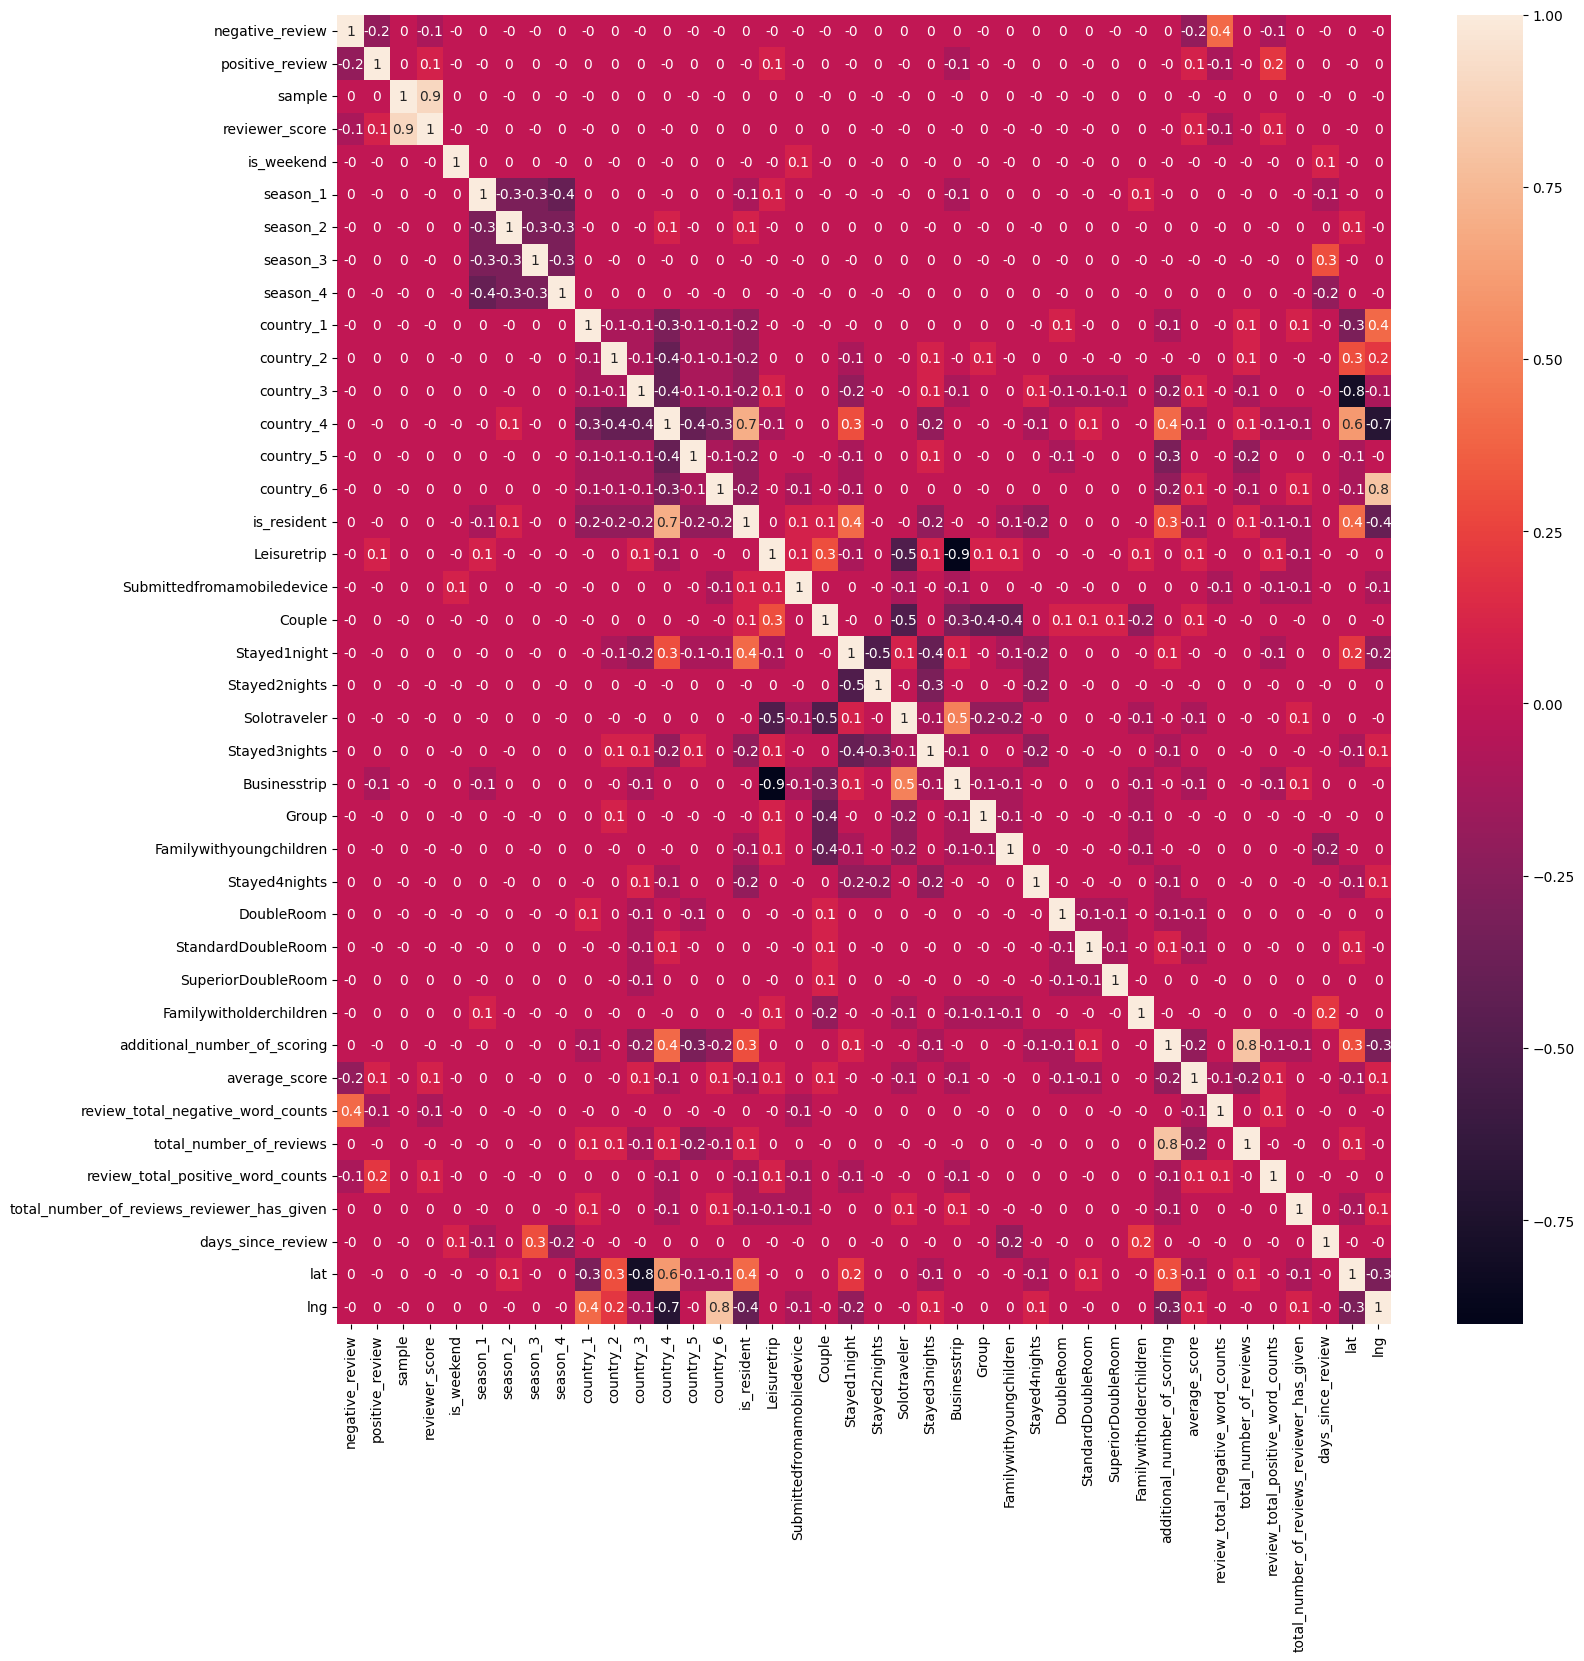

In [52]:
# Построим тепловую матрицу корреляции признаков
fig = plt.figure(figsize=(17, 17))
sns.heatmap(round(data.corr(), 1), annot=True)

In [53]:
# Удаляем признаки с показателем корреляции >=+-0.7
data = data.drop(['Businesstrip', 'country_4', 'country_6', 'additional_number_of_scoring'], axis=1)

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   negative_review                             515738 non-null  int64  
 1   positive_review                             515738 non-null  int64  
 2   sample                                      515738 non-null  int64  
 3   reviewer_score                              515738 non-null  float64
 4   is_weekend                                  515738 non-null  int64  
 5   season_1                                    515738 non-null  int64  
 6   season_2                                    515738 non-null  int64  
 7   season_3                                    515738 non-null  int64  
 8   season_4                                    515738 non-null  int64  
 9   country_1                                   515738 non-null  int64  
 

In [55]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'].astype('int')

In [56]:
# Разделим признаки на непрерывные и категориальные
num_cols = ['average_score', 'review_total_negative_word_counts',\
            'total_number_of_reviews', 'review_total_positive_word_counts', \
            'total_number_of_reviews_reviewer_has_given', 'days_since_review']

cat_cols = ['is_resident', 'Leisuretrip', 'Submittedfromamobiledevice', 'Couple', 'Stayed1night',\
            'Stayed2nights', 'Solotraveler', 'Stayed3nights', 'Group', 'Familywithyoungchildren',\
            'Stayed4nights', 'DoubleRoom', 'StandardDoubleRoom', 'SuperiorDoubleRoom',\
            'Familywitholderchildren', 'negative_review', 'positive_review', 'is_weekend',\
            'season_1', 'season_2', 'season_3', 'season_4', 'country_1', 'country_2',\
            'country_3', 'country_5', 'lat', 'lng']

Text(0.5, 1.0, 'Значимость непрерывных признаков')

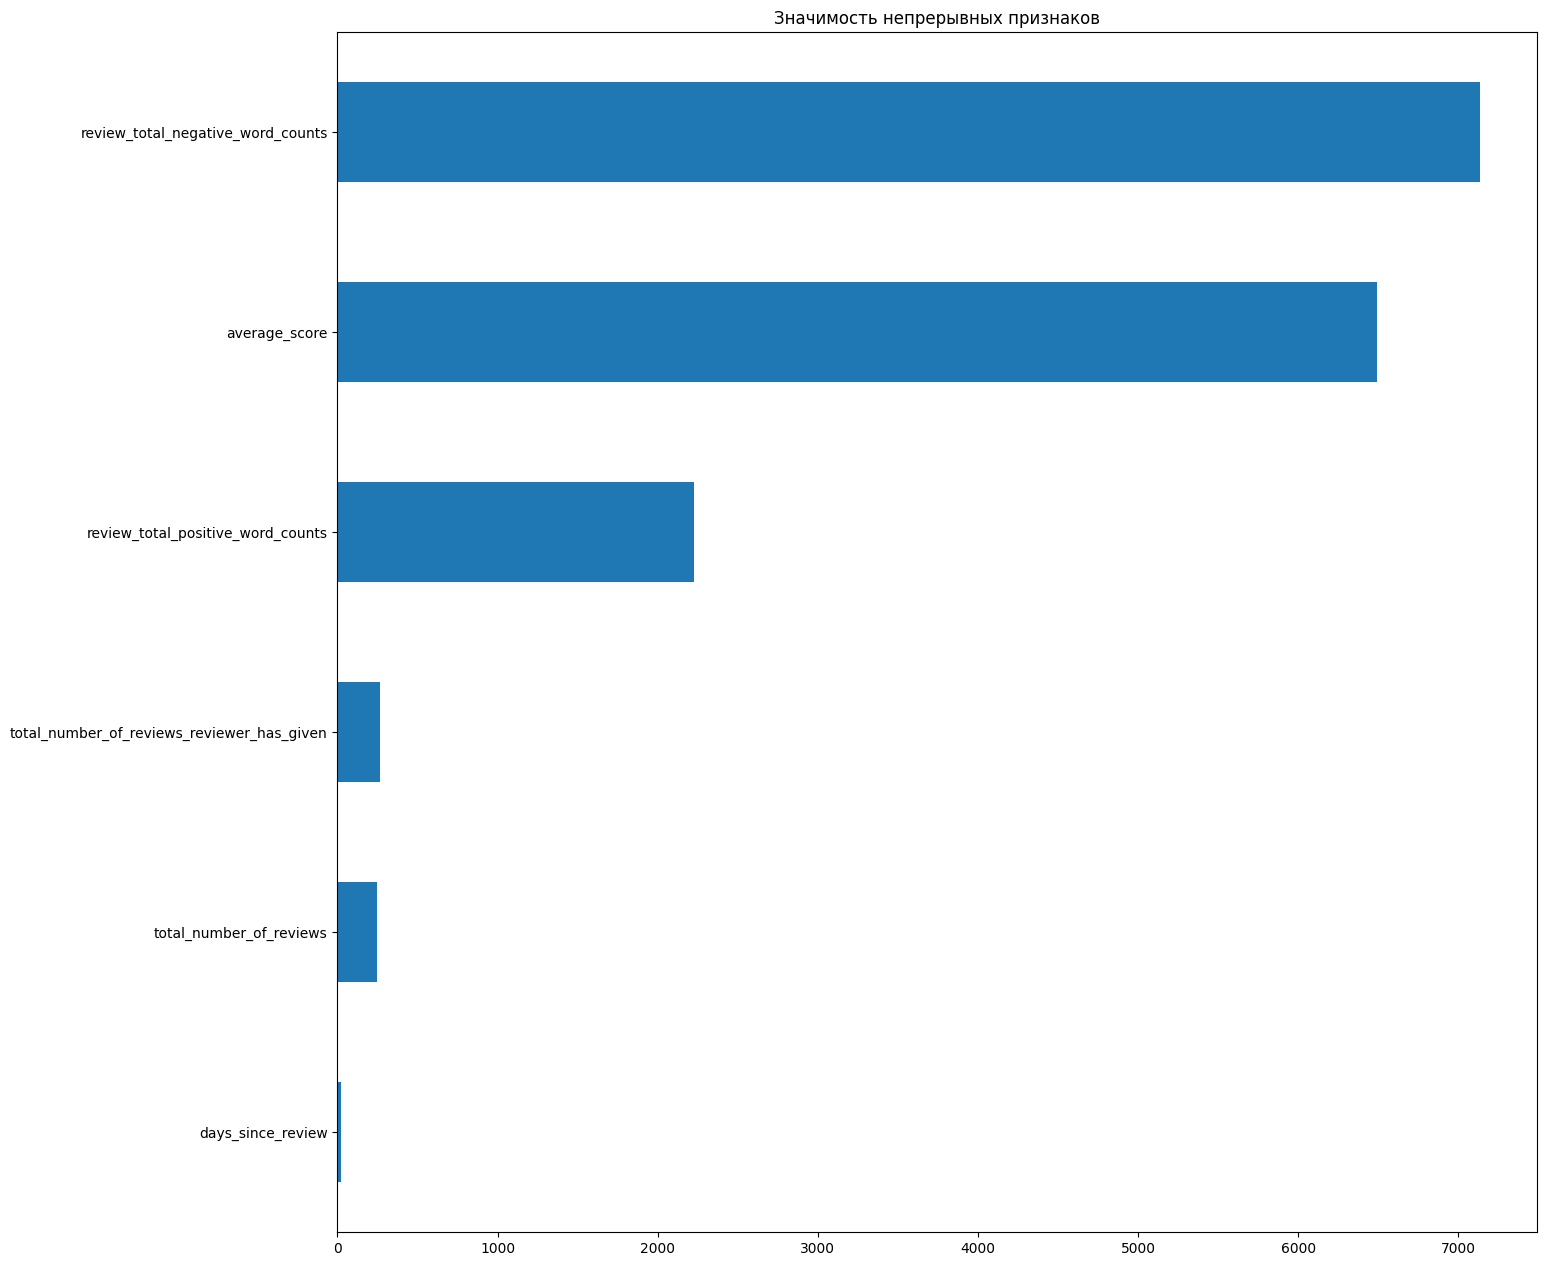

In [57]:
# для оценки значимости непрерывных переменных будем использовать тест ANOVA

from sklearn.feature_selection import f_classif # anova

fig = plt.figure(figsize=(12,12))
axes = fig.add_axes([0, 0, 1, 1])
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
axes.set_title('Значимость непрерывных признаков')

Text(0.5, 1.0, 'Значимость категориальных признаков')

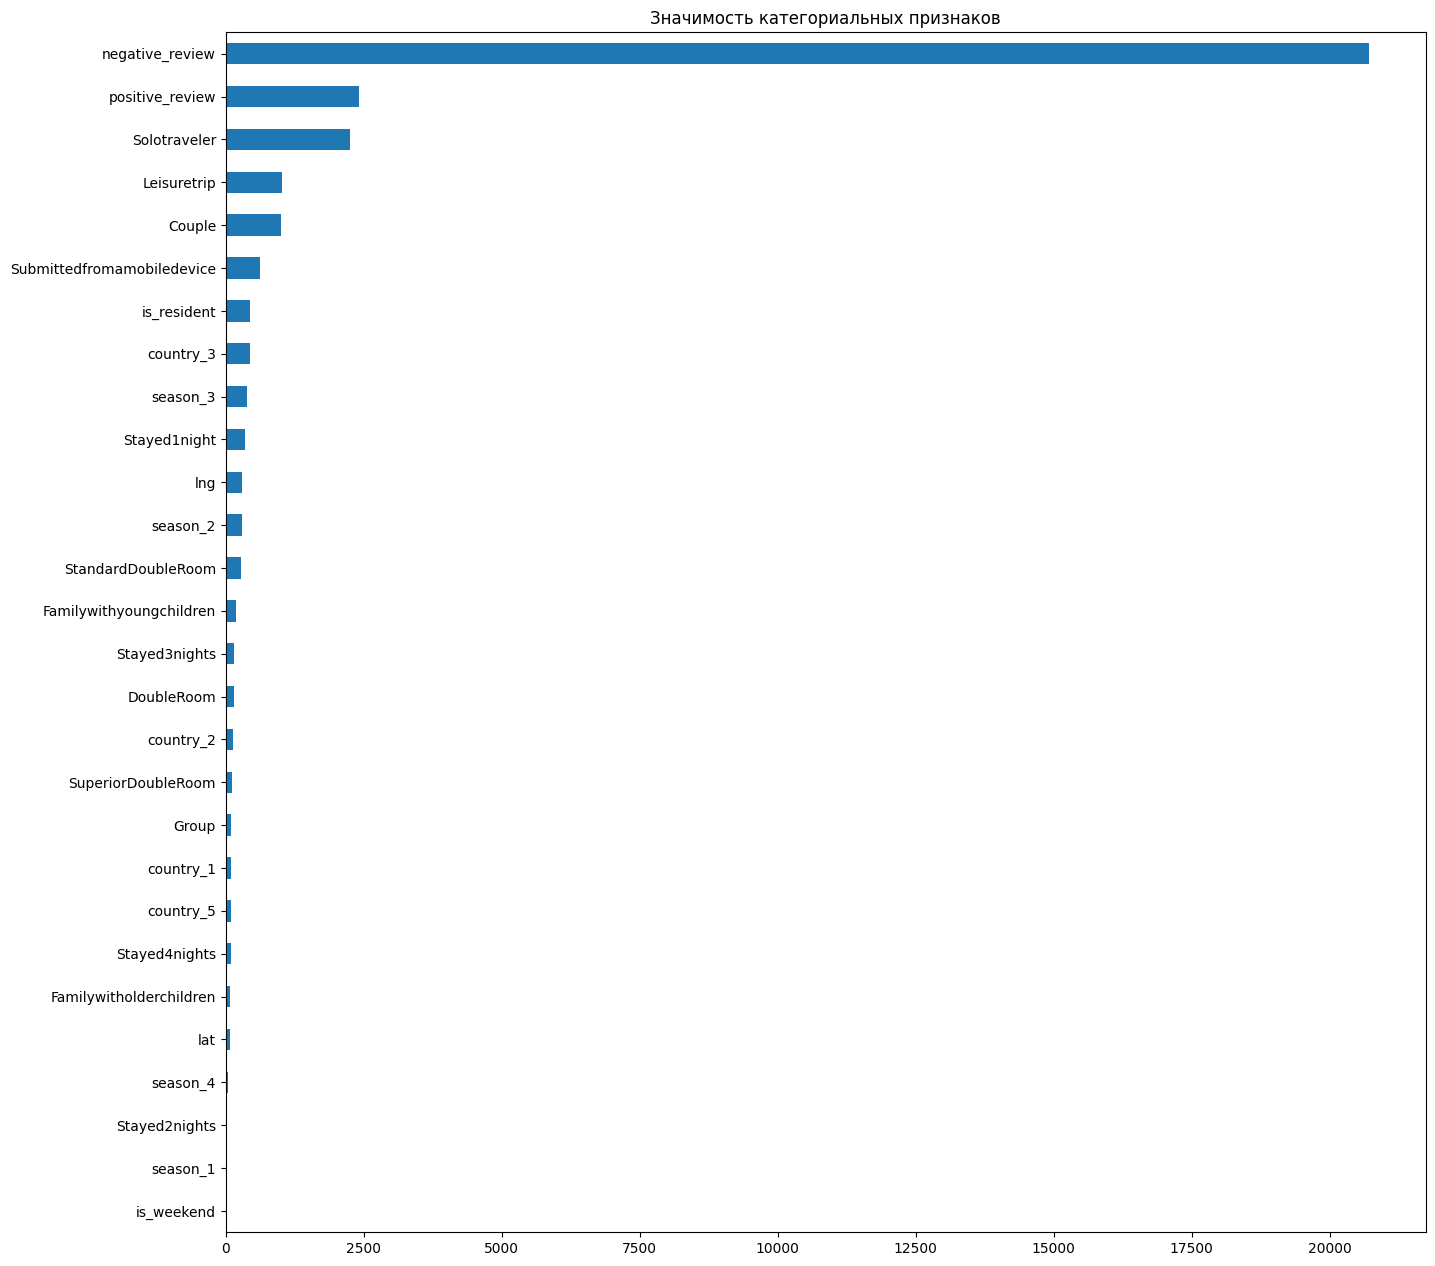

In [58]:
# для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат

from sklearn.feature_selection import chi2 # хи-квадрат

fig = plt.figure(figsize=(12,12))
axes = fig.add_axes([0, 0, 1, 1])
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
axes.set_title('Значимость категориальных признаков')

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   negative_review                             515738 non-null  int64  
 1   positive_review                             515738 non-null  int64  
 2   sample                                      515738 non-null  int64  
 3   reviewer_score                              515738 non-null  float64
 4   is_weekend                                  515738 non-null  int64  
 5   season_1                                    515738 non-null  int64  
 6   season_2                                    515738 non-null  int64  
 7   season_3                                    515738 non-null  int64  
 8   season_4                                    515738 non-null  int64  
 9   country_1                                   515738 non-null  int64  
 

## Этап обучения модели

In [60]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [61]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [62]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 35), (386803, 35), (386803, 34), (309442, 34), (77361, 34))

In [63]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [64]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [65]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  

In [66]:
# Создаем функцию для вычисления целевой метрики
def mape( test , pred ): 
 test, pred = np.array(test), np.array(pred)
 return np.mean(np.abs((test - pred) / test)) * 100

In [67]:
mape = mape(y_test, y_pred)
print('MAPE:', mape)

MAPE: 13.430154873026689


<AxesSubplot: >

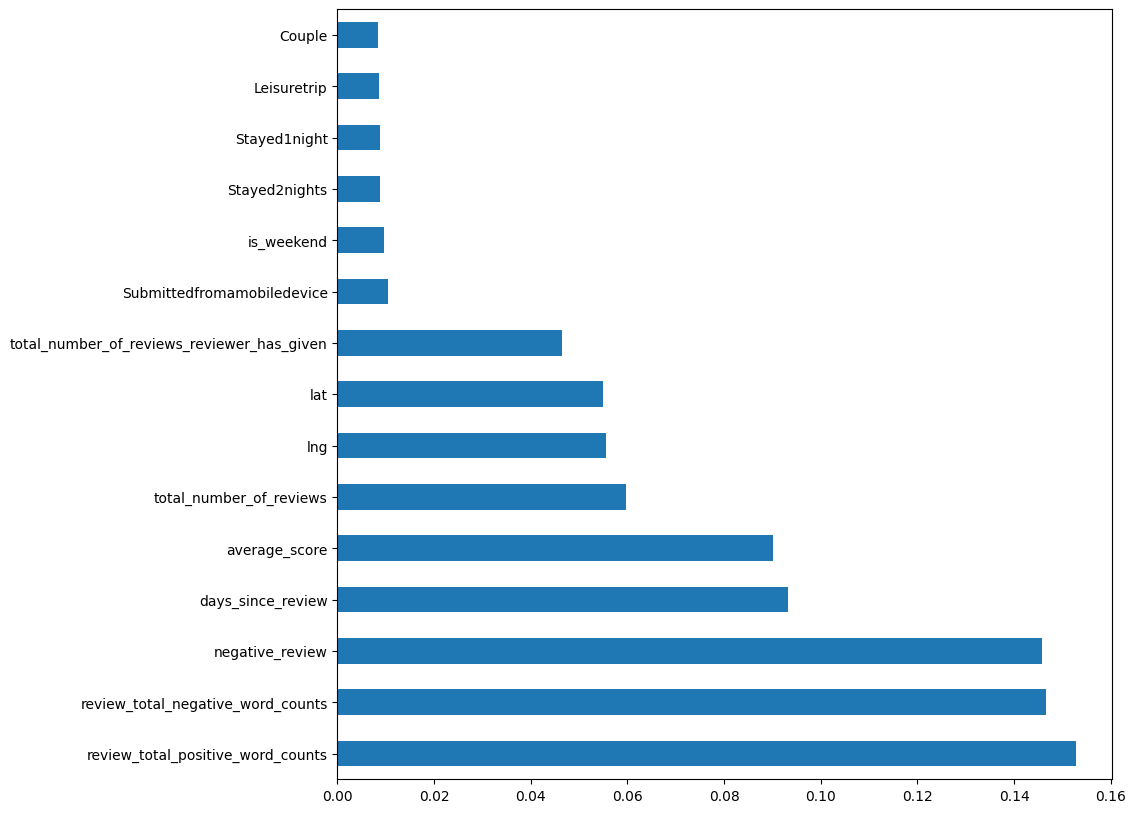

In [68]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [69]:
test_data.sample(10)

,negative_review,positive_review,reviewer_score,is_weekend,season_1,season_2,season_3,season_4,country_1,country_2,...,SuperiorDoubleRoom,Familywitholderchildren,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng
114154,0,1,0.0,0,0,1,0,0,0,0,...,0,0,0.869565,0.000000,0.019968,0.012658,0.002825,0.286301,0.620755,0.996660
7798,1,1,0.0,0,1,0,0,0,0,0,...,0,0,0.652174,0.078431,0.067420,0.078481,0.036723,0.039726,0.919912,0.011099
82216,1,1,0.0,1,0,0,0,1,0,0,...,0,1,0.500000,0.053922,0.111145,0.010127,0.002825,0.667123,0.920117,0.011283
127920,1,0,0.0,1,0,1,0,0,0,0,...,0,0,0.891304,0.019608,0.099296,0.000000,0.016949,0.810959,0.919440,0.014499
27341,1,1,0.0,0,1,0,0,0,0,1,...,0,0,0.586957,0.147059,0.127744,0.088608,0.019774,0.520548,0.994726,0.309228
122347,1,0,0.0,0,0,1,0,0,0,0,...,0,0,0.673913,0.075980,0.022674,0.000000,0.000000,0.326027,0.680822,0.158305
78922,1,1,0.0,1,0,0,1,0,1,0,...,0,0,0.565217,0.034314,0.069405,0.012658,0.056497,0.390411,0.374995,0.566656
9013,0,1,0.0,1,0,0,0,1,0,0,...,0,0,0.782609,0.004902,0.121188,0.007595,0.000000,0.687671,0.921115,0.014124
46893,0,1,0.0,0,0,0,1,0,0,0,...,0,0,0.413043,0.000000,0.543874,0.035443,0.008475,0.867123,0.918869,0.020628
126869,1,1,0.0,1,1,0,0,0,0,0,...,0,0,0.739130,0.031863,0.171228,0.058228,0.019774,0.524658,0.919052,0.008651


In [70]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [71]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [72]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.3s finished


In [73]:
predict_submission

array([8.767, 6.762, 8.173, ..., 8.225, 9.687, 7.072])

In [74]:
list(sample_submission)

['reviewer_score', 'id']

In [75]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.767,488440
1,6.762,274649
2,8.173,374688
3,9.521,404352
4,9.112,451596
5,8.671,302161
6,8.247,317079
7,7.702,13963
8,8.822,159785
9,7.948,195089
